In [26]:
from tensorflow.keras.models import Model
import scipy as sp
import importlib
import tensorflow

#### Load data

In [27]:
from tensorflow.keras.datasets import mnist
(X_train,Y_train), (X_test,Y_test) = mnist.load_data()
print(X_train.shape)
print(type(X_train))

(60000, 28, 28)
<class 'numpy.ndarray'>


#### Preprocess Data

In [28]:
X_train = X_train.reshape((X_train.shape[0],
                           X_train.shape[1],
                           X_train.shape[2],
                           1)
                         )
X_test = X_test.reshape((X_test.shape[0],
                         X_test.shape[1],
                         X_test.shape[2],
                         1)
                       )

# Normalize
X_train = X_train/255
X_test  = X_test/255

# Change dtype
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

Y_train = Y_train.astype('float32')
Y_test  = Y_test.astype('float32')

# print shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


#### Make Model

In [29]:
import tensorflow
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras import regularizers, optimizers
import numpy as np

#### Model Architechture

In [30]:
np.random.seed(0)
model = Sequential()
model.add(Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(10,activation='softmax'))

model.summary()
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(X_train,Y_train,batch_size=32,epochs=5,validation_split=0.1,shuffle=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 128)        

#### Train Model

In [35]:
model.evaluate(X_test, Y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.028117560658205185, 0.9905]

In [38]:
# Global Average pooling weights
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(128, 10)

In [39]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))

In [40]:
features, results = cam_model.predict(X_test)
features.shape

(10000, 3, 3, 128)

In [42]:
import matplotlib.pyplot as plt

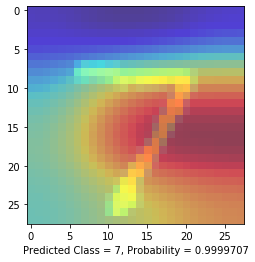

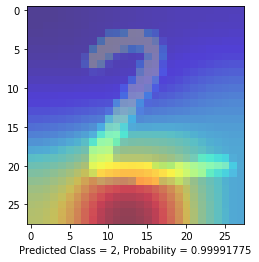

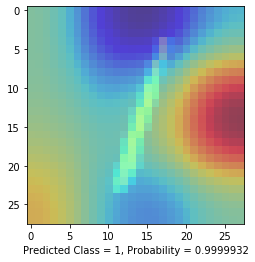

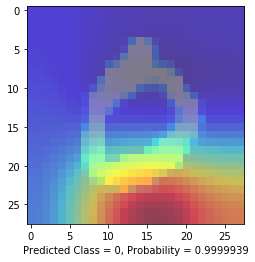

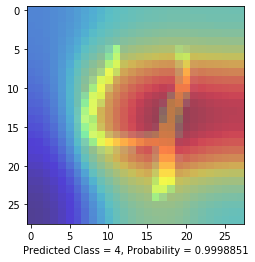

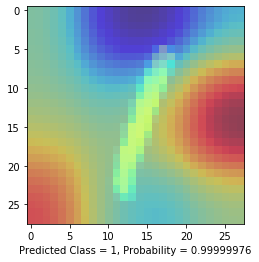

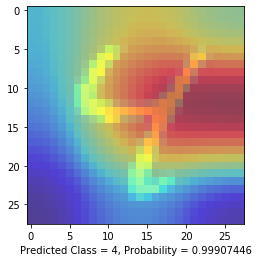

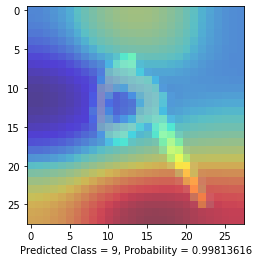

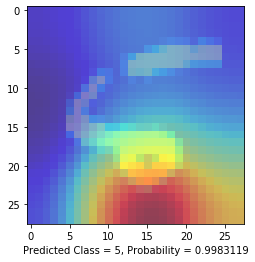

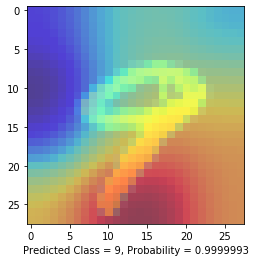

In [43]:
for idx in range(10):
    features_for_one_img = features[idx,:,:,:]
    height_roomout = X_train.shape[1]/features_for_one_img.shape[0]
    width_roomout  = X_train.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    pred = np.argmax(results[idx])
    
    
    plt.figure(facecolor='white')
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' +str( pred )+ ', Probability = ' + str(results[idx][pred])

    plt.xlabel(buf)

    plt.imshow(np.squeeze(X_test[idx],-1), alpha=0.5)
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.show()